# Consistency Checking

This script tests that timestamp of traces are consistant.

# Import & Constants

## Fuseki Endpoint : you might want to change it!

In [1]:
FUSEKI_DATASET = "evalafel" # Change according your own dataset name
SPARQL_ENDPOINT = "http://localhost:3030/%s/query" % FUSEKI_DATASET

## Imports, constants settings

In [2]:
from SPARQLWrapper import SPARQLWrapper, CSV
from rdflib import Literal
import numpy as np
import pandas as pd
from io import BytesIO
import datetime
import gc
import matplotlib.dates as plt_dates
import matplotlib.pyplot as plt
import dateutil
import seaborn as sns
from sklearn.preprocessing import Normalizer
from scipy.stats import pearsonr

In [3]:
SPARQL_PREFIX = """
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX extafl: <http://vocab.afel-project.eu/extension/>
    PREFIX afl: <http://vocab.afel-project.eu/>
    PREFIX sch: <http://schema.org/>
    
"""

In [4]:
# Setting seaborn to have proper visualisation adapted to jupyter notebook
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [5]:
def sparql_to_dataframe(query, **kwargs):
    sparql = SPARQLWrapper(SPARQL_ENDPOINT)
    sparql.setQuery(query)
    sparql.setReturnFormat(CSV)
    res = sparql.query().convert()
    try:
        with BytesIO(res) as sio:
            return pd.read_csv(sio, **kwargs)
    finally:
        del res
        gc.collect()

# Plot Didact. & Afel App. activities over time

In [6]:
def get_activities_times():
    query = SPARQL_PREFIX + """
    SELECT ?time ?location (COUNT(?id) as ?nbAct)
    WHERE {
        $activity afl:eventID ?id .
        $activity rdf:type ?activityType .
        $activity afl:eventEndDate ?time .
        $activity sch:location ?location .
    }
    GROUP BY ?time ?location
    ORDER BY ?time
    """
    return sparql_to_dataframe(query, parse_dates=[0])

In [7]:
df_act = get_activities_times()

In [8]:
df_act_dida = df_act.loc[df_act.location == 'https://didactalia.net',('time', 'nbAct')].groupby(pd.Grouper(key='time', freq='1H')).sum().reset_index()

In [9]:
df_act_afel = df_act.loc[df_act.location == 'http://afel-project.eu/',('time', 'nbAct')].groupby(pd.Grouper(key='time', freq='1H')).sum().reset_index()

In [10]:
def draw_act_over_time(dida, afel):
    dts_dida = plt_dates.date2num(dida.time.values)
    dts_afel = plt_dates.date2num(afel.time.values)
    fig = plt.figure(figsize=(20,3))
    plt.plot_date(dts_dida, dida.nbAct.values, fmt='r', linewidth=2)
    plt.plot_date(dts_afel, afel.nbAct.values, fmt='b', linewidth=2)
    fig.show()

/Users/venant/DEVELOPPEMENT/COURANT/Galway/AFEL_Evaluation2/venv/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


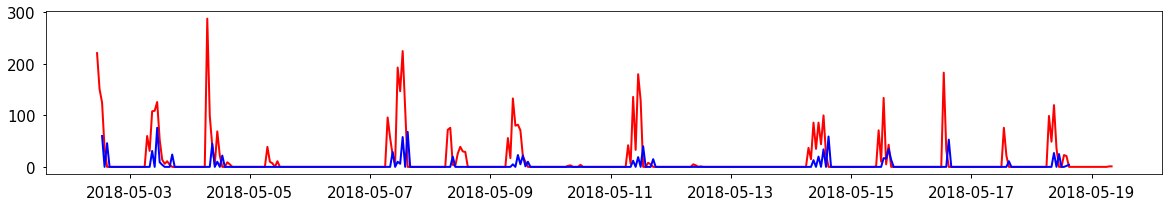

In [11]:
draw_act_over_time(df_act_dida, df_act_afel)

In [12]:
del df_act, df_act_dida, df_act_afel
gc.collect()

2184

# Check that activities happened during the knowledge test

In [13]:
def get_learners_test_times():
    query = SPARQL_PREFIX + """
    SELECT ?username (MIN(?time) AS ?preTime) (MAX(?time) AS ?postTime)
    WHERE {
        $action a sch:ChooseAction .
        $action sch:object $question .
        $action sch:agent $user .
        $question a sch:Question .
        $user a afl:User .
        $question sch:isPartOf $quest .
        $quest a extafl:Questionnaire .
        $action sch:endTime ?time .
        $quest sch:identifier ?questId .
        $user afl:userName ?username .
        FILTER regex(?questId, "^AFEL_2_KNOW") .
    }
    GROUP BY ?username
    ORDER BY ?pretTime ?postTime
    """
    return sparql_to_dataframe(query, parse_dates=[1, 2])

In [14]:
def get_learners_acitivity_times():
    query = SPARQL_PREFIX + """
    SELECT ?username ?time ?location ?activityType
    WHERE {
        $activity rdf:type ?activityType .
        $activity afl:eventEndDate ?time .
        $activity sch:location ?location .
        $activity afl:user $user .
        $user afl:userName ?username .
        FILTER(?activityType IN (afl:ArtifactView, afl:Search, afl:DidactaliaGamePlayed, extafl:RecommendedActivityView, extafl:ScopeView)) .
    }
    ORDER BY ?time
    """
    return sparql_to_dataframe(query, parse_dates=[1])

In [15]:
df_test_times = get_learners_test_times() 

In [16]:
df_lear_act_times = get_learners_acitivity_times()

In [17]:
df_lear_act_times.activityType = df_lear_act_times.activityType.str.split('/').str.get(-1).str.lower()

In [18]:
df_merged = pd.merge(df_lear_act_times, df_test_times, how='left', on='username', validate='many_to_one')

In [19]:
df_merged['catTime'] = 0
df_merged.loc[df_merged.time < df_merged.preTime, 'catTime'] = -1
df_merged.loc[df_merged.time > df_merged.postTime, 'catTime'] = 1

In [20]:
df_merged.loc[:,('username', 'location', 'catTime')].groupby(['catTime', 'location']).count()

username
catTime location                         
-1      https://didactalia.net        145
 0      http://afel-project.eu/         2
        https://didactalia.net       1123
 1      http://afel-project.eu/       273
        https://didactalia.net       1320